In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

from pathlib import Path
from omegaconf import OmegaConf
from IPython.display import HTML


In [2]:
def collect_one(run, csv_file):
    cfg = OmegaConf.load(run / '.hydra' / 'config.yaml')
    
    text_model = cfg['text_model']['name']
    motion_model = cfg['motion_model']['name']

    symm = '_symm' if 'symm' in run.as_posix() else ''
    no_bkb = '_nobkb' if 'bkb_feats' in cfg['optim']['loss'] and not cfg['optim']['loss']['bkb_feats'] else ''
    loss = cfg['optim']['loss']['_target_'].replace('models.losses.', '') + symm + no_bkb

    dataset = cfg['data']['train']['name']
    common_space_dim = cfg['common_space_dim']

    if 'MoViT' in motion_model:
        time_mask = 'use_time_padding_mask' in cfg['motion_model']['module'] and cfg['motion_model']['module']['use_time_padding_mask']
        graph_based = 'use_skeleton_connection_mask' in cfg['motion_model']['module'] and cfg['motion_model']['module']['use_skeleton_connection_mask']
        time_mask = '-timemask' if time_mask else ''
        graph_based = '-graph' if graph_based else ''
        motion_model = motion_model + '-' + cfg['motion_model']['module']['body_repres'] + time_mask + graph_based

    seed = cfg['optim']['seed']
    
    csv_path = run / csv_file
    if not csv_path.exists():
        print(f'Skipping not found: {csv_path}')
        return pd.DataFrame()
    
    data = pd.read_csv(csv_path)
    if data.empty:
        print(f'Pred file is empty: {csv_path}')
    
    data['text_model'] = text_model
    data['motion_model'] = motion_model
    data['loss'] = loss
    data['split_seed'] = seed
    data['dataset'] = dataset
    data['common_space_dim'] = common_space_dim
    
    return data

def collect_all(root, csv_file):
    root = Path(root)
    metrics = [collect_one(csvf.parents[0], csv_file) for csvf in list(root.rglob(csv_file))]
    metrics = pd.concat(metrics, ignore_index=True)
    return metrics

default_fields_dict = {
    'r1': lambda x: u"{:.1f}".format(x),
    'r5': lambda x: u"{:.1f}".format(x),
    'r10': lambda x: u"{:.1f}".format(x),
    'meanr': lambda x: u"{:.1f}".format(x),
    'medr': lambda x: int(x),
    'spice': lambda x: u"{:.3f}".format(x),
    'spacy': lambda x: u"{:.3f}".format(x),
}
def render_to_latex(metrics, rename_func=default_fields_dict, **latex_kwargs):
    m = metrics.copy()
    # renaming
    for col, lambda_fn in rename_func.items():
        m[col] = m[col].apply(lambda_fn)
    # m = m.applymap(lambda x: u"{:.2f}".format(x))
    ltex = m.style.to_latex(
        **latex_kwargs
    )
    return ltex

In [3]:
# Compute metrics for each detected run

def summarize_metrics(metrics, dataset=None, text_model=None, motion_model=None, loss=None, common_space_dim=[256], melt=True):
    if dataset is not None:
        metrics = metrics[(metrics['dataset'] == dataset)]
        metrics.drop(columns="dataset", inplace=True)

    # TODO: as of now, there is only one split seed.
    # In the future, we would have to average among different splits
    metrics.drop(columns="split_seed", inplace=True)

    id_vars = ['text_model', 'motion_model', 'loss', 'common_space_dim']

    if common_space_dim is not None:
        metrics = metrics[metrics['common_space_dim'].isin(common_space_dim)]
        if len(common_space_dim) == 1:
            metrics.drop(columns="common_space_dim", inplace=True)
            id_vars.remove('common_space_dim')
    if text_model is not None:
        metrics = metrics[metrics['text_model'].isin(text_model)]
        if len(text_model) == 1:
            metrics.drop(columns="text_model", inplace=True)
            id_vars.remove('text_model')
    if motion_model is not None:
        metrics = metrics[metrics['motion_model'].isin(motion_model)]
        if len(motion_model) == 1:
            metrics.drop(columns="motion_model", inplace=True)
            id_vars.remove('motion_model')
    if loss is not None:
        metrics = metrics[metrics['loss'].isin(loss)]
        if len(loss) == 1:
            metrics.drop(columns="loss", inplace=True)
            id_vars.remove('loss')

    if melt:
        metrics = metrics.melt(id_vars=id_vars, var_name="metric")
        metrics = metrics.pivot(index=id_vars, columns="metric", values="value")

    return metrics

In [4]:
# rename content of the table
def rename_fn(v):
    mapping = {'ContrastiveFixed': 'Triplet',
               'InfoNCELoss': 'InfoNCE'}
    if v in mapping:
        return mapping[v]
    return v

# Results on KIT

In [5]:
# collect all data on kit
ROOT = "runs/"

metrics = collect_all(ROOT, 'metrics_test.csv')
metrics = summarize_metrics(
    metrics, 
    dataset='kit', 
    loss=['InfoNCELoss', 'InfoNCECrossConsistent', 'InfoNCECrossConsistent_symm', 'InfoNCECrossConsistent_symm_nobkb'],
    motion_model=['BiGRU', 'UpperLowerGRU', 'DGSTGCN', 'MoViT-body-parts-timemask']
    )

metrics.drop(columns=['mAP_primary', 'mAP_top', 'top1_acc_primary', 'top1_acc_top', 'top5_acc_primary', 'top5_acc_top'], inplace=True)
metrics = metrics[['r1', 'r5', 'r10', 'meanr', 'medr', 'spice', 'spacy']]
metrics = metrics.rename(index=rename_fn)

latex = render_to_latex(
    metrics, 
    caption="Caption",
    clines="skip-last;data",
    hrules=True,
    column_format="llccccccc"
)

metrics
# print(latex)

/tmp/ipykernel_1187294/2432531798.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics.drop(columns="dataset", inplace=True)
/tmp/ipykernel_1187294/2432531798.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics.drop(columns="split_seed", inplace=True)


metric                                                                                     r1  \
text_model              motion_model              loss                                          
BERTSentenceEncoderLSTM BiGRU                     InfoNCECrossConsistent             2.985075   
                                                  InfoNCECrossConsistent_symm        2.985075   
                                                  InfoNCECrossConsistent_symm_nobkb  5.223881   
                                                  InfoNCE                            3.731343   
                        DGSTGCN                   InfoNCECrossConsistent             6.503198   
                                                  InfoNCECrossConsistent_symm        5.970149   
                                                  InfoNCECrossConsistent_symm_nobkb  5.756930   
                                                  InfoNCE                            6.183369   
                        MoViT-body-parts-timemask InfoNCECrossConsistent             5.543710   
                                                  InfoNCECrossConsistent_symm        5.543710   
                                                  InfoNCECrossConsistent_symm_nobkb  5.437100   
                                                  InfoNCE                            5.330490   
                        UpperLowerGRU             InfoNCECrossConsistent             5.437100   
                                                  InfoNCECrossConsistent_symm        4.477612   
                                                  InfoNCECrossConsistent_symm_nobkb  4.264392   
                                                  InfoNCE                            3.198294   
CLIP                    BiGRU                     InfoNCECrossConsistent             6.289979   
                                                  InfoNCECrossConsistent_symm        6.396588   
                                                  InfoNCECrossConsistent_symm_nobkb  6.396588   
                                                  InfoNCE                            6.609808   
                        DGSTGCN                   InfoNCECrossConsistent             7.249467   
                                                  InfoNCECrossConsistent_symm        8.422175   
                                                  InfoNCECrossConsistent_symm_nobkb  8.208955   
                                                  InfoNCE                            7.249467   
                        MoViT-body-parts-timemask InfoNCECrossConsistent             7.036247   
                                                  InfoNCECrossConsistent_symm        7.249467   
                                                  InfoNCECrossConsistent_symm_nobkb  5.863539   
                                                  InfoNCE                            6.503198   
                        UpperLowerGRU             InfoNCECrossConsistent             6.183369   
                                                  InfoNCECrossConsistent_symm        5.543710   
                                                  InfoNCECrossConsistent_symm_nobkb  5.010661   
                                                  InfoNCE                            6.396588   

metric                                                                                      r5  \
text_model              motion_model              loss                                           
BERTSentenceEncoderLSTM BiGRU                     InfoNCECrossConsistent             18.976546   
                                                  InfoNCECrossConsistent_symm        18.976546   
                                                  InfoNCECrossConsistent_symm_nobkb  21.855011   
                                                  InfoNCE                            15.245203   
                        DGSTGCN                   InfoNCECrossConsistent             24.733475   
               

# Results on HumanML3D

In [6]:
# collect all data on human-ml3d
ROOT = "runs/"

metrics = collect_all(ROOT, 'metrics_test.csv')
metrics = summarize_metrics(
    metrics, 
    dataset='humanml',
    loss=['InfoNCELoss', 'InfoNCECrossConsistent', 'InfoNCECrossConsistent_symm', 'InfoNCECrossConsistent_symm_nobkb'],
    motion_model=['BiGRU', 'UpperLowerGRU', 'DGSTGCN', 'MoViT-body-parts-timemask']
)
metrics

metrics.drop(columns=['mAP_primary', 'mAP_top', 'top1_acc_primary', 'top1_acc_top', 'top5_acc_primary', 'top5_acc_top'], inplace=True)
metrics = metrics[['r1', 'r5', 'r10', 'meanr', 'medr', 'spice', 'spacy']]
metrics = metrics.rename(index=rename_fn)

latex = render_to_latex(
    metrics, 
    caption="Caption",
    clines="skip-last;data",
    hrules=True,
    column_format="lllccccccc"
)

metrics

# render to latex
# print(latex)

/tmp/ipykernel_1187294/2432531798.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics.drop(columns="dataset", inplace=True)
/tmp/ipykernel_1187294/2432531798.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics.drop(columns="split_seed", inplace=True)


metric                                                                                     r1  \
text_model              motion_model              loss                                          
BERTSentenceEncoderLSTM BiGRU                     InfoNCECrossConsistent             2.678253   
                                                  InfoNCECrossConsistent_symm        2.702059   
                                                  InfoNCECrossConsistent_symm_nobkb  2.690156   
                                                  InfoNCE                            2.928223   
                        DGSTGCN                   InfoNCECrossConsistent             3.428163   
                                                  InfoNCECrossConsistent_symm        3.606713   
                                                  InfoNCECrossConsistent_symm_nobkb  0.595167   
                                                  InfoNCE                            2.047375   
                        MoViT-body-parts-timemask InfoNCECrossConsistent             2.832996   
                                                  InfoNCECrossConsistent_symm        2.940126   
                                                  InfoNCECrossConsistent_symm_nobkb  3.249613   
                                                  InfoNCE                            2.535412   
                        UpperLowerGRU             InfoNCECrossConsistent             2.321152   
                                                  InfoNCECrossConsistent_symm        2.321152   
                                                  InfoNCECrossConsistent_symm_nobkb  2.654446   
                                                  InfoNCE                            2.428282   
CLIP                    BiGRU                     InfoNCECrossConsistent             4.047137   
                                                  InfoNCECrossConsistent_symm        3.880490   
                                                  InfoNCECrossConsistent_symm_nobkb  0.607071   
                                                  InfoNCE                            3.368647   
                        DGSTGCN                   InfoNCECrossConsistent             4.130461   
                                                  InfoNCECrossConsistent_symm        4.416141   
                                                  InfoNCECrossConsistent_symm_nobkb  4.130461   
                                                  InfoNCE                            4.130461   
                        MoViT-body-parts-timemask InfoNCECrossConsistent             3.868587   
                                                  InfoNCECrossConsistent_symm        3.797167   
                                                  InfoNCECrossConsistent_symm_nobkb  3.749554   
                                                  InfoNCE                            3.535293   
                        UpperLowerGRU             InfoNCECrossConsistent             3.344840   
                                                  InfoNCECrossConsistent_symm        3.237710   
                                                  InfoNCECrossConsistent_symm_nobkb  0.583264   
                                                  InfoNCE                            3.106773   

metric                                                                                      r5  \
text_model              motion_model              loss                                           
BERTSentenceEncoderLSTM BiGRU                     InfoNCECrossConsistent             11.248661   
                                                  InfoNCECrossConsistent_symm        11.320081   
                                                  InfoNCECrossConsistent_symm_nobkb  11.248661   
                                                  InfoNCE                            11.772408   
                        DGSTGCN                   InfoNCECrossConsistent             15.081538   
               

## Performance varying common space

/tmp/ipykernel_1187294/2432531798.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics.drop(columns="dataset", inplace=True)
/tmp/ipykernel_1187294/2432531798.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics.drop(columns="split_seed", inplace=True)
/tmp/ipykernel_1187294/2432531798.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics.drop(columns="dataset", inplace=True)
/tmp/ipykernel_1187294/2432531798.py:10

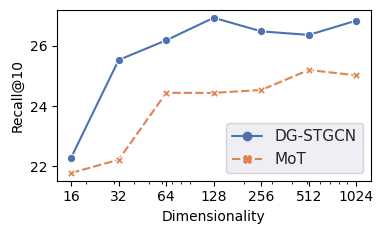

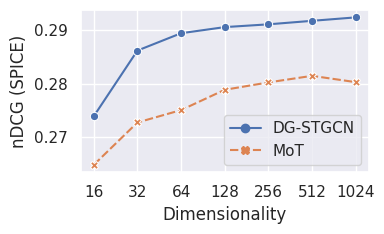

In [7]:
# collect all data on human-ml3d
ROOT = "runs/"

metrics = collect_all(ROOT, 'metrics_test.csv')

def show_plot(metrics, dataset='kit', metric='r10'):
    metrics = summarize_metrics(
        metrics,
        dataset=dataset,
        loss=['InfoNCELoss'],
        motion_model=['DGSTGCN', 'MoViT-body-parts-timemask'],
        text_model=['CLIP'],
        common_space_dim=[16, 32, 64, 128, 256, 512, 1024],
        melt=False
    )
    # metrics = metrics[["r10", "spice", "motion_model", "common_space_dim"]]
    # metrics = metrics.melt(
    #     id_vars=["motion_model", "common_space_dim"], 
    #     var_name="metric", 
    #     value_name="value")
    metrics = metrics.replace(
    {'BERTSentenceEncoderLSTM': 'BERT+LSTM',
     'MoViT-body-parts-timemask': 'MoT',
     'DGSTGCN': 'DG-STGCN',
     'UpperLowerGRU': 'UL-GRU'
     })

    f, ax = plt.subplots(figsize=(4, 2.5))
    sns.set_theme()
    ax.set_xscale("log")
    ax.set_xticks([16, 32, 64, 128, 256, 512, 1024])
    ax.set_xticklabels([16, 32, 64, 128, 256, 512, 1024])
    ax.set(xlabel='Dimensionality', ylabel='Recall@10' if metric=='r10' else 'nDCG (SPICE)')
    p = sns.lineplot(data=metrics, x="common_space_dim", y=metric, hue="motion_model", style="motion_model", markers=True)
    p.legend_.set_title('')
    f.tight_layout()

show_plot(metrics, dataset='humanml', metric='r10')
plt.savefig('outputs/figures/sweep_dim_r10.pdf')
show_plot(metrics, dataset='humanml', metric='spice')
plt.savefig('outputs/figures/sweep_dim_spice.pdf')

## Triplet vs InfoNCE

/tmp/ipykernel_1187294/2432531798.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics.drop(columns="common_space_dim", inplace=True)


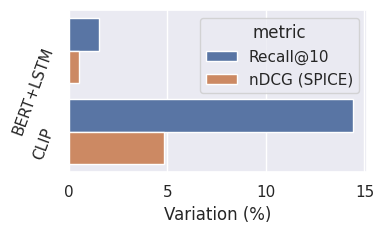

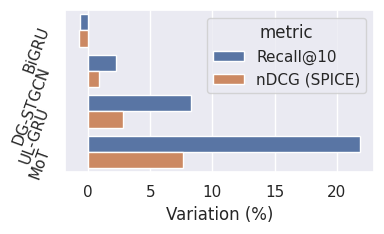

In [8]:
ROOT = "runs/"

metrics = collect_all(ROOT, 'metrics_test.csv')
metrics = summarize_metrics(
    metrics,
    common_space_dim=[256],
    loss=['InfoNCELoss', 'ContrastiveFixed'],
    motion_model=['BiGRU', 'UpperLowerGRU', 'DGSTGCN', 'MoViT-body-parts-timemask'],
    melt=False
)
def compute_loss_improvement(x):
    v = (x.iloc[1] - x.iloc[0]) / x.iloc[0]
    return v * 100

metrics = metrics.sort_values('loss')
metrics = metrics.replace(
    {'BERTSentenceEncoderLSTM': 'BERT+LSTM',
     'MoViT-body-parts-timemask': 'MoT',
     'DGSTGCN': 'DG-STGCN',
     'UpperLowerGRU': 'UL-GRU'
     })
metrics = metrics.groupby(['motion_model', 'text_model', 'dataset'], as_index=False).agg({
    # 'r5': compute_loss_improvement,
    'r10': compute_loss_improvement,
    'spice': compute_loss_improvement
})

metrics_per_motion_model = metrics.groupby('motion_model', as_index=False).agg({
    # 'r5': 'mean',
    'r10': 'mean',
    'spice': 'mean'
})
metrics_per_motion_model = metrics_per_motion_model.sort_values(by='r10')
metrics_per_motion_model = metrics_per_motion_model.melt(
    id_vars="motion_model", 
    var_name="metric", 
    value_name="value").rename(columns={'motion_model': 'model'})

metrics_per_text_model = metrics.groupby('text_model', as_index=False).agg({
    # 'r5': 'mean',
    'r10': 'mean',
    'spice': 'mean'
})
metrics_per_text_model = metrics_per_text_model.melt(
    id_vars="text_model", 
    var_name="metric", 
    value_name="value").rename(columns={'text_model': 'model'})

def show_plot(df):
    f, ax = plt.subplots(figsize=(4, 2.5))
    sns.set_theme()
    df = df.replace({'r10': 'Recall@10', 'spice': 'nDCG (SPICE)'})
    p = sns.barplot(data=df, x="value", y="model", hue="metric")
    ax.set(xlabel='Variation (%)', ylabel=None)
    ax.tick_params(axis='y', rotation=70)

    f.tight_layout()

show_plot(metrics_per_text_model)
plt.savefig('outputs/figures/nce_vs_triplet_text.pdf')
show_plot(metrics_per_motion_model)
plt.savefig('outputs/figures/nce_vs_triplet_motion.pdf')
